<a href="https://colab.research.google.com/github/spros1/DistanceJoin/blob/main/DistanceJoin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

For two sets given A and B ( with values (ID,X,Y) ) : <br>
Find the pairs (a,b), where a in Α and b in Β, 
to wich it applies : d(a,b) ≤ c, where c parameter given from the user 

In [1]:
# importing the required module
import matplotlib.pyplot as plt
import numpy as np

###Create two lists of points for initial tests
### At next phases this will change to csvs

In [2]:
marks = [['I',6,3],['I',2,2],['I',1,2],['I',7,9], ['I',4,5]]
train = [['T', 5, 5], ['T',9,7]]

print(marks)
print(train)

[['I', 6, 3], ['I', 2, 2], ['I', 1, 2], ['I', 7, 9], ['I', 4, 5]]
[['T', 5, 5], ['T', 9, 7]]


### Plot the points ( marks -> o , train -> x )

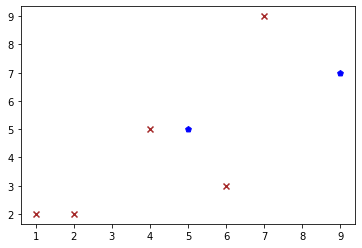

In [3]:
for a in range(len(marks)):
  mx = marks[a][1]
  my = marks[a][2]
  plt.scatter(mx, my, marker='x', color = 'brown')

for b in range(len(train)):
  tx = train[b][1]
  ty = train[b][2]
  plt.scatter(tx, ty, marker='p', color = 'blue')

plt.show()

Get the value for range from user and 

In [4]:
range_val = 0
try:
  range_val = int(input("Enter your value for range : "))
except ValueError:
    print("This is not a number")    

Enter your value for range : 5


#### Create a function that calculates the distance between two points

In [5]:
# Function to calculate distance between points using Pythagoras' theorem
import math
def distance(i1 , t1 , i2 , t2):
 
    return math.sqrt(math.pow(i2 - i1, 2) + math.pow(t2 - t1, 2) * 1.0)

In [6]:
# function to call in order to calculate the points of train that are in range of points of input

def check_in_range(i, t, r):

  for a in range(len(i)):
   for b in range(len(t)):
    print(i[a])
    print(t[b])
    dist = distance(i[a][2] , i[a][1], t[b][2] , t[b][1])

    if dist <= range_val :
     print("Points in range :", dist, "<=", r)
    else : 
     print("Points out of range :", dist, ">", r)
    
    print("----------------------")

### Now call the functions in order to get the requested results

In [7]:
check_in_range(marks, train, range_val)

['I', 6, 3]
['T', 5, 5]
Points in range : 2.23606797749979 <= 5
----------------------
['I', 6, 3]
['T', 9, 7]
Points in range : 5.0 <= 5
----------------------
['I', 2, 2]
['T', 5, 5]
Points in range : 4.242640687119285 <= 5
----------------------
['I', 2, 2]
['T', 9, 7]
Points out of range : 8.602325267042627 > 5
----------------------
['I', 1, 2]
['T', 5, 5]
Points in range : 5.0 <= 5
----------------------
['I', 1, 2]
['T', 9, 7]
Points out of range : 9.433981132056603 > 5
----------------------
['I', 7, 9]
['T', 5, 5]
Points in range : 4.47213595499958 <= 5
----------------------
['I', 7, 9]
['T', 9, 7]
Points in range : 2.8284271247461903 <= 5
----------------------
['I', 4, 5]
['T', 5, 5]
Points in range : 1.0 <= 5
----------------------
['I', 4, 5]
['T', 9, 7]
Points out of range : 5.385164807134504 > 5
----------------------
